In [1]:

import numpy as np
import csv, os
import pingouin as pg
import re
import seaborn as sns
import pandas as pd
import h5py

In [429]:
class AnalysisHCI:
    
    def __init__(self, base_dir, filenames=None):
        # prepare data
        self.base_dir = base_dir
        self.pre_dict = dict(timestamp=[], exp_num=[], age=[], gender=[], height=[], weight=[], 
                             feet=[], vr_exp=[], vr_sickness=[])
        
        self.main_dict = dict(timestamp=[], exp_num=[], interface=[], trial=[])
        self.ssq_dict = dict(general_discomfort=[], fatigue=[], headache=[], eye_strain=[], diff_focus=[], 
                             salivation=[], sweating=[], nausea=[], diff_concentrating=[], full_of_head=[],
                            blurred_vision=[], dizzy_open=[], dizzy_closed=[], vertigo=[], stomach=[], burping=[])
        self.tlx_dict = dict(mental=[], physical=[], temporal=[], performance=[], effort=[], frustration=[])
        self.filenames = filenames
        self.pre_questionaire()
        self.main_questionaire()
        
        # Make dataFrame
        self.make_data_frame()
        
        self.questionaire = dict(geq=self.geq_interface, ssq= self.ssq_interface, 
                                 tlx=self.tlx_interface)
        
    def pre_questionaire(self):
        pdk = self.pre_dict.keys()
        with open(os.path.join(self.base_dir, self.filenames[0]), 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i ==0:
                        continue
                    for k, v in zip(pdk, row):
                        self.pre_dict[k].append(v)
    
    def main_questionaire(self):
        mqk = self.main_dict.keys()
        sqk = self.ssq_dict.keys()
        tqk = self.tlx_dict.keys()
        self.geq_dict = dict()
        with open(os.path.join(self.base_dir, self.filenames[1]), 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i ==0:
                        a = 0
                        for r in row[10:43]:
                            a += 1
                            self.geq_dict[re.search('\(.*\)|\s-\s.*', r).group(0)] = []
                            print(a, r)
                        gqk = self.geq_dict.keys()
                        print(gqk)
                    else:
                        for mk, r in zip(mqk, row[:4]):
                            self.main_dict[mk].append(r)
                        for tk, r in zip(tqk, row[4:10]):
                            self.tlx_dict[tk].append(int(r))
                        for gk, r in zip(gqk, row[10:43]):
                            self.geq_dict[gk].append(int(r))
                        for sk, r in zip(sqk, row[43:]):
                            self.ssq_dict[sk].append(int(r))

    def make_data_frame(self):
        mdf = pd.DataFrame(data=self.main_dict)
        gdf = pd.DataFrame(data=self.geq_dict)
        tdf = pd.DataFrame(data=self.tlx_dict)
        sdf = pd.DataFrame(data=self.ssq_dict)
        del mdf['timestamp']
        
        self.combined_geq_data = pd.concat([mdf, gdf], axis=1)
        self.combined_ssq_data = pd.concat([mdf, sdf], axis=1)
        self.combined_tlx_data = pd.concat([mdf, tdf], axis=1)
        
        self.geq_interface = self.combined_geq_data.groupby(['interface'])
        
        self.ssq_interface = self.combined_ssq_data.groupby(['interface'])
        
        self.tlx_interface = self.combined_tlx_data.groupby(['interface'])
        
    def save_plot_avg(self, indices, questionaire='geq', path=None, name=None,
                     ylbl='Average', kind='box'):
        
        interfaces = ['Arm-swing', 'Seamless-walk', 'Teleport']
        groups = []
        for interface in interfaces:
            group = self.questionaire[questionaire].get_group(interface).iloc[:,indices].sum(axis=1).reset_index()
            del group['index']
            group = group.rename(columns={0:interface})
            groups.append(group)
        interfaces_df = pd.concat(groups,axis=1)
        print(interfaces_df)
        interfaces_df.plot(kind='box')
        plt.ylabel(ylbl)
        plt.xlabel('interface')
        plt.title(name)

        plt.savefig(os.path.join(path, name))
        
    def iqr(self, indices=None, questionaire='geq'):    
        
        q1 = self.questionaire[questionaire].iloc[:,indices].quantile(.25)
        q3 = self.questionaire[questionaire].iloc[:,indices].quantile(.75)
        
        return q3 - q1 
    
    def weighted_ssq(self):
        self.n = [0, 5, 6, 7, 8, 14, 15]
        self.o = [0, 1, 2, 3, 4, 8, 10]
        self.d = [4, 7, 9, 10, 11, 12, 13]
        interfaces = ['Arm-swing', 'Seamless-walk', 'Teleport']
        nauseas = []
        oculomotor = []
        disorientation = []
        total_score = []
        for interface in interfaces:
            group = self.questionaire['ssq'].get_group(interface).iloc[:,3:]
            n = (group.iloc[:, self.n] * 9.54).sum(axis=1).reset_index()
            del n['index']
            n = n.rename(columns={0:interface})
            
            o = (group.iloc[:, self.o] * 7.58).sum(axis=1).reset_index()
            del o['index']
            o = o.rename(columns={0:interface})
            
            d = (group.iloc[:, self.d] * 13.74).sum(axis=1).reset_index()
            del d['index']
            d = d.rename(columns={0:interface})
            
            ts = (group.sum(axis=1) * 3.74).reset_index()
            del ts['index']
            ts = ts.rename(columns={0:interface})
            nauseas.append(n)
            oculomotor.append(o)
            disorientation.append(d)
            total_score.append(ts)
            
        nauseas_df = pd.concat(nauseas,axis=1)
        oculomotor_df = pd.concat(oculomotor,axis=1)
        disorientation_df = pd.concat(disorientation,axis=1)
        total_score_df = pd.concat(total_score,axis=1)
        
        nauseas_df.plot(kind='box')
        #plt.ylabel(ylbl)
        plt.xlabel('interface')
        plt.title('Nausea')
        
        oculomotor_df.plot(kind='box')
        #plt.ylabel(ylbl)
        plt.xlabel('interface')
        plt.title('Oculomotor')
        
        disorientation_df.plot(kind='box')
        #plt.ylabel(ylbl)
        plt.xlabel('interface')
        plt.title('Disorientation')
        
        total_score_df.plot(kind='box')
        #plt.ylabel(ylbl)
        plt.xlabel('interface')
        plt.title('Total Score')
        
        
    

In [430]:
print(os.getcwd())
main_dict = ['timestamp', 'exp_num', 'interface', 'trial', '']
filenames = ['pre_question.csv', 'main_question.csv']
hci = AnalysisHCI(base_dir=os.getcwd(),filenames=filenames)
#hci.save_plot_avg([4,12, 17,19,22],path='./', name='Competence')
#hci.weighted_ssq()

/home/kevinjeon/uorl_jeon/home/gist-mit/analysis
1 나는 만족스러움을 느꼈다 (I felt content)
2 나는 숙련됨을 느꼈다 (I felt skilful)
3 나는 게임의 스토리가 흥미로웠다 (I was interested in the game's story)
4 나는 재미있다고 생각했다 (I thought it was fun)
5 나는 게임에 완전히 몰두했다 (I was fully occupied with the game)
6 나는 행복함을 느꼈다 (I felt happy) 
7 나는 기분이 나빠졌다 (It gave me a bad mood) 
8 나는 다른 생각이 들었다 (I thought about other things) 
9 나는 귀찮아졌다 (I found it tiresome) 
10 나는 능숙함을 느꼈다 (I felt competent) 
11 나는 힘들었다고 생각한다 (I thought it was hard) 
12 미적으로 만족스러웠다 (It was aesthetically pleasing) 
13 나는 내 주변의 모든 것을 잊었다 (I forgot everything around me)
14 나는 기분이 좋았다 (I felt good)
15 나는 잘했다 (I was good at it)
16 나는 지루함을 느꼈다 (I felt bored)
17 나는 성공했다고 느꼈다 (I felt successful)
18 나는 상상력이 풍부하다고 느꼈다 (I felt successful)
19 나는 뭔가를 탐색할 수 있다고 느꼈다 (I felt that I could explore things)
20 나는 즐겼다 (I enjoyed it)
21 나는 게임의 목표에 빨리 도달했다 (I was fast at reaching the game's target)
22 나는 짜증이 났다 (I felt annoyed)
23 나는 압박감을 느꼈다 (I felt pressured)
24 나는 화가 났다 (I felt irrit

In [432]:
base_dir = os.getcwd()
data_dir = '../IntellignetCarpet_zzz/IntellignetCarpet_zzz/data'


jhc_joy2
fb_0.hdf5
fb_1.hdf5
fb_2.hdf5
fb_3.hdf5
uws_joy2
fb_0.hdf5
fb_1.hdf5
fb_2.hdf5
fb_3.hdf5
cyh_joy2
fb_0.hdf5
fb_1.hdf5
fb_2.hdf5
fb_3.hdf5
lsh_joy2
fb_0.hdf5
fb_1.hdf5
fb_2.hdf5
fb_3.hdf5
pdh_joy2
fb_0.hdf5
fb_1.hdf5
fb_2.hdf5
fb_3.hdf5


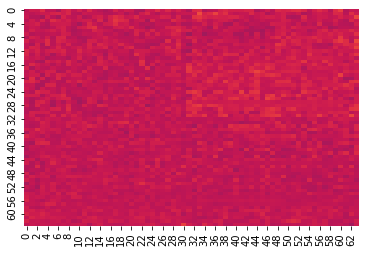

In [550]:
import h5py
import seaborn as sns
datas = os.listdir(data_dir)

plt.show()
n = 0
#os.mkdir('./fig/test')
#os.mkdir('./fig')
for data in datas:
    if 'joy2'in data:
        print(data)
        datafiles = os.listdir(os.path.join(data_dir, data))
        n += 1
        for d, datafile in enumerate(datafiles):
            print(datafile)
            with h5py.File(os.path.join(data_dir, data) + '/' + datafile, "r") as f:
                pressure = np.array(list(f["pressure"]))
                pressure = remove_zero(pressure)
                pressure = pressure - normalize_matrix
                for i in range(0, len(pressure), 200):
                    #print(press - normalize_matrix)
                    #hm = sns.heatmap(press - normalize_matrix, cbar=False, vmin=-100, vmax=100)
                    hm = sns.heatmap(pressure[i], cbar=False, vmin=-100, vmax=100)
                    hm.figure.savefig("./fig/test/{}_{}_{}.png".format(data, datafile, i))
                hm = None


In [7]:

def remove_zero(data):
    idxs = []
    for i in range(len(data)):
        if data[i].mean() == 0.0:
            idxs.append(i)
    data = np.delete(data, idxs, 0)
    return data

In [625]:
def make_matrix(path):
    '''
    Initialzie the MIT Sensor
    '''
    with h5py.File(os.path.join(path)) as f:
        pressure = np.array(list(f["pressure"]))
        pressure = remove_zero(pressure)
        pressure = np.mean(pressure, axis=0)
    return pressure

(array([], dtype=int64), array([], dtype=int64))


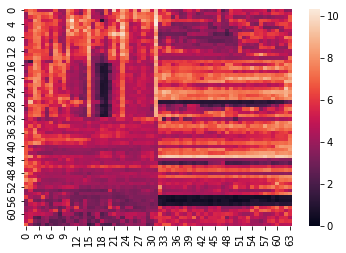

In [592]:
test_matrix('../IntellignetCarpet_zzz/IntellignetCarpet_zzz/data/normalize/norm_matrix.hdf5')

In [591]:
#os.mkdir('./fig/whereisbug')
def test_matrix(path):
    with h5py.File(os.path.join(path)) as f:
        pressure = np.array(list(f["pressure"]))
        pressure = remove_zero(pressure)
        pressure = np.std(pressure, axis=0)
        print(np.where(pressure==0))
        hm = sns.heatmap(pressure, cbar=True, vmin=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


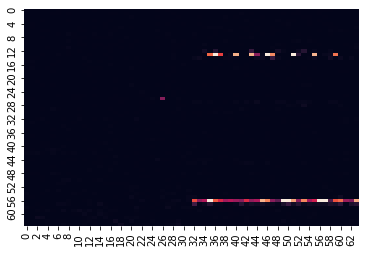

In [26]:
#os.mkdir('./fig/test3')
path = '../IntellignetCarpet_zzz/IntellignetCarpet_zzz/data/jhc_joy_final/fb.hdf5'
with h5py.File(os.path.join(path)) as f:
    data = np.array(list(f["pressure"]))
    data = remove_zero(data)
    #print(data[:9, :, :].shape)
    mu = np.mean(data[:200], axis=0)
    std = np.std(data[:200], axis=0)
    #data = data - normalize_matrix
    data = (data - mu) / (std **2 * 50)
    data = np.clip(data, 0.0, 1.0)
    #data = (data + 1.0) / 2.0 
    #data *= 255
    for i in range(0, len(data), 100):
        #print(press - normalize_matrix)
        #hm = sns.heatmap(press - normalize_matrix, cbar=False, vmin=500, vmax=700)
        hm = sns.heatmap(data[i], cbar=False, vmin=0, vmax=1)
        hm.figure.savefig("./fig/test4/{}.png".format(i))
        hm = None


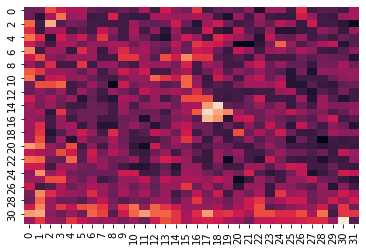

In [66]:
path = '../IntellignetCarpet_zzz/IntellignetCarpet_zzz/data/norm_hc'
p = [[0,32,0,32], [32, 64, 0, 32], [32, 64, 32, 64], [0,32, 32, 64],]
files = os.listdir(path)
mu2 = np.zeros((64, 64))
for file in files:
    if 'no' in file:
        with h5py.File(os.path.join(path, file)) as f:
            data = np.array(list(f["pressure"]))
            data = remove_zero(data)
            #mu2 = np.zeros((data))
            mu = np.mean(data, axis=0)
    else:
        os.mkdir('./fig/test{}'.format(file[:-5]))
        with h5py.File(os.path.join(path, file)) as f:
            data = np.array(list(f["pressure"]))
            data = remove_zero(data)
            num = int(file[:-5])
            mu2_part = np.mean(data, axis=0)
            #mu2_part[p[num]]
            #data = (data - mu) / 200
            #data = np.clip(data, 0.0, 1.0)
            mu2_part[p[num][0]:p[num][1],p[num][2]:p[num][3]] = 0
            mu2 += mu2_part
            for i in range(0, len(data), 10):
                hm = sns.heatmap(data[i][p[num][0]:p[num][1],p[num][2]:p[num][3]], cbar=False)
                hm.figure.savefig("./fig/test{}/{}.png".format(file[:-5],i))
mu2 /= 3

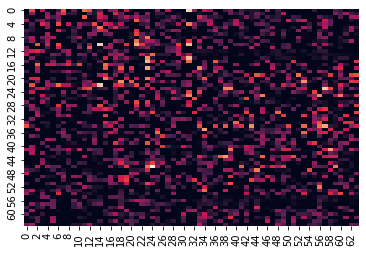

In [67]:
#os.mkdir('./fig/test_no/')
#os.mkdir('./fig/test_yes/')
for file in files:
    if 'no' not in file:
        with h5py.File(os.path.join(path, file)) as f:
            data = np.array(list(f["pressure"]))
            data = remove_zero(data)
            data_no = (data - mu) / 200
            data_no = np.clip(data_no, 0.0, 1.0)
            data_no *= 255
            data_yes = (data - mu2) / 200
            data_yes = np.clip(data_yes, 0.0, 1.0)
            data_yes *= 255
            for i in range(0, len(data), 5):
                hm = sns.heatmap(data_no[i], cbar=False)
                hm.figure.savefig("./fig/test_no/{}_{}.png".format(file[:-5],i))
                
                hm2= sns.heatmap(data_yes[i], cbar=False)
                hm2.figure.savefig("./fig/test_yes/{}_{}.png".format(file[:-5],i))
            

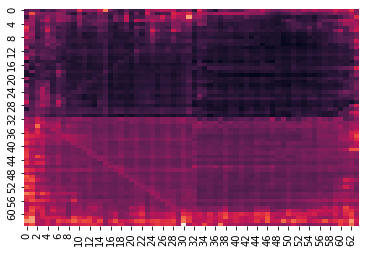

In [54]:
os.mkdir('./fig/tt')

hm = sns.heatmap(mu, cbar=False)
hm.figure.savefig("./fig/tt/1.png")

hm2 = sns.heatmap(mu2, cbar=False)
hm2.figure.savefig("./fig/tt/2.png")

In [59]:
class Preprocessing_data:
    
    def __init__(self, base_dir, ouput_dir):
        
        self.base_dir = base_dir
        
    ## def mu 값 visaulize(뛰어다닌 부분 제외 하고 mean 값), (가만히 냅둔 mean 값): 
    
    ## def normalize 적용 후 data visualize
    
    ## def normalize 적용 전 data visualize 

[[432.38875 433.4575  433.52375 ... 438.6275  442.35375 435.47625]
 [435.50375 444.51875 436.295   ... 435.2475  438.45125 435.6275 ]
 [430.35625 436.85875 433.315   ... 433.97    436.13125 441.97625]
 ...
 [444.04875 449.08375 439.575   ... 440.22375 442.59125 439.03375]
 [448.6625  449.3775  438.86625 ... 442.415   448.49875 440.85625]
 [441.79625 444.0525  438.4575  ... 441.01125 446.20875 439.32125]]


[[577.865 577.9   577.875 ... 584.34  589.605 579.865]
 [579.595 589.13  580.02  ... 583.33  589.695 580.655]
 [577.72  583.125 577.745 ... 578.365 582.85  588.845]
 ...
 [590.965 596.2   586.825 ... 587.035 590.33  584.54 ]
 [594.97  594.455 584.575 ... 587.44  592.405 587.185]
 [588.995 592.155 584.565 ... 587.345 590.37  585.365]]
